# Combine data

In [116]:
import pandas as pd
import os
import numpy as np
from itertools import product
from shapely.geometry import LinearRing, Polygon, Point, LineString, box
import geopandas as gpd
import matplotlib.pyplot as plt
import math
from math import radians, sin, cos, asin, sqrt, atan2
from time import time
from scipy.interpolate import RegularGridInterpolator

%matplotlib inline

pickles = '../data/pickles/'

# Read Pickle Files

In [2]:
os.listdir(pickles)

['bathymetry.pkl',
 'ca_counties.pkl',
 'crit_species.pkl',
 'kelp_biomass.pkl',
 'mpa.pkl',
 'nes_occupation.pkl',
 'qcew_occupation.pkl',
 'sst_ca.pkl']

In [140]:
#we will need to convert some geometries from lat, lon to lon,lat
def flip_coords(geom):
    if type(geom) == Polygon:
        coords = geom.exterior.coords.xy 
        geomtype = 'Polygon'
    elif type(geom) == LineString:
        coords = geom.coords.xy
        geomtype = 'LineString'
    elif type(geom) == Point:
        coords = geom.coords.xy
        geomtype = 'Point'
    else:
        print("not a known geom type")
        return 
    flipped_coords = list(zip(coords[1],coords[0]))
    if geomtype == 'Polygon':
        return Polygon(flipped_coords) 
    elif geomtype == 'LineString':
        return LineString(flipped_coords)
    elif geomtype == 'Point':
        return Point(flipped_coords)

In [187]:
#Pickle files come from data/read_data.ipynb and
#bathymetry is not a gpd df
bathymetry = pd.read_pickle(pickles+'bathymetry.pkl')
print(bathymetry.shape)
bathymetry.head()

(5371, 4)


,x,y,z,geometry
1614,-124.45,40.400000,-50.0,POINT (-124.45 40.40000000000003)
1615,-124.45,40.416667,-38.0,POINT (-124.45 40.41666666666669)
1616,-124.45,40.433333,-32.0,POINT (-124.45 40.43333333333336)
1617,-124.45,40.450000,-29.0,POINT (-124.45 40.45000000000002)
1618,-124.45,40.466667,-31.0,POINT (-124.45 40.46666666666669)


In [142]:
#in lon, lat format
counties = pd.read_pickle(pickles+'ca_counties.pkl')
counties.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,6,75,00277302,0500000US06075,06075,San Francisco,06,121485107,479107241,"POLYGON ((-122.511983 37.77113, -122.465396 37..."
705,6,87,00277308,0500000US06087,06087,Santa Cruz,06,1152967426,419570389,"POLYGON ((-122.317682 37.186945, -122.152774 3..."
713,6,31,00277280,0500000US06031,06031,Kings,06,3598593366,5453080,"POLYGON ((-120.315068 35.907186, -119.959058 3..."
899,6,85,00277307,0500000US06085,06085,Santa Clara,06,3344209919,33276429,"POLYGON ((-122.190402 37.431472, -122.144933 3..."
915,6,21,00277275,0500000US06021,06021,Glenn,06,3403149421,33704225,"POLYGON ((-122.911794 39.799485, -122.046471 3..."


In [143]:
#in lon lat format except for leatherbacks which is all messed up
crit_species = pd.read_pickle(pickles+'crit_species.pkl')
crit_species.head()

,species,geometry
0,black abalone,"POLYGON ((-123.5053264870277 38.7405412355896,..."
1,black abalone,POLYGON ((-123.0726524775298 38.31072869617242...
2,black abalone,POLYGON ((-122.5006060204515 37.50355915762907...
3,black abalone,POLYGON ((-122.5097393606829 37.50326748590578...
4,black abalone,POLYGON ((-122.4114904047584 37.26741997175435...


In [144]:
#in lat lon format
protected_areas = pd.read_pickle(pickles+'mpa.pkl')
protected_areas.Geometry = protected_areas.Geometry.apply(flip_coords)
protected_areas = gpd.GeoDataFrame(protected_areas, crs = {'init' :'epsg:4326'}, geometry='Geometry')

In [145]:
#does not have geom. just county names (and fips state and county codes)
occupation_nes = pd.read_pickle(pickles+'nes_occupation.pkl')
occupation_nes.head()

,estab,estab_f,naics,year,State,fips_state,fips_county,name,STATE,COUNTY,STNAME,CTYNAME,population,pct
0,42,NaN,11411,2010,CA,6,1,Alameda County,6,1,California,Alameda County,1513402,0.000028
1,71,NaN,11411,2011,CA,6,1,Alameda County,6,1,California,Alameda County,1532215,0.000046
2,63,NaN,11411,2012,CA,6,1,Alameda County,6,1,California,Alameda County,1556648,0.000040
3,65,NaN,11411,2013,CA,6,1,Alameda County,6,1,California,Alameda County,1582936,0.000041
4,64,NaN,11411,2014,CA,6,1,Alameda County,6,1,California,Alameda County,1611572,0.000040


In [146]:
#does not have geom. just county names (and fips state and county codes)
occupation_qcew = pd.read_pickle(pickles+'qcew_occupation.pkl')
occupation_qcew.head()

,area_fips,industry_code,agglvl_code,size_code,year,disclosure_code,annual_avg_estabs,annual_avg_emplvl,fips_county,fips_state,State,name,fips_class_code,STATE,COUNTY,STNAME,CTYNAME,population,estab_pct,emp_pct
0,06007,11251,77,0,2013,N,1,0,7,6,CA,Butte County,H1,6,7,California,Butte County,221768,0.000005,0.000000
1,06015,11251,77,0,2013,N,1,0,15,6,CA,Del Norte County,H1,6,15,California,Del Norte County,27830,0.000036,0.000000
2,06015,11411,77,0,2013,NaN,39,81,15,6,CA,Del Norte County,H1,6,15,California,Del Norte County,27830,0.001401,0.002911
3,06019,11251,77,0,2013,N,4,0,19,6,CA,Fresno County,H1,6,19,California,Fresno County,953787,0.000004,0.000000
4,06023,11251,77,0,2013,NaN,6,19,23,6,CA,Humboldt County,H1,6,23,California,Humboldt County,134444,0.000045,0.000141


In [147]:
#in lat lon format
kelp_biomass =pd.read_pickle(pickles+'kelp_biomass.pkl')
kelp_biomass.geometry = kelp_biomass.geometry.apply(flip_coords)
kelp_biomass.head()
#kelp_biomass.geometry.apply(type).unique() all points

,lat,lon,biomass,geometry
0,32.519277,-117.142836,265.0,POINT (-117.1428356 32.51927713)
1,32.519547,-117.143155,635.0,POINT (-117.1431554 32.5195474)
2,32.519548,-117.142836,275.0,POINT (-117.142836 32.51954776)
3,32.519548,-117.142197,272.0,POINT (-117.1421972 32.51954849)
4,32.519818,-117.143156,565.0,POINT (-117.1431559 32.51981803)


In [219]:
#will be converted to lon lat format
sst = pd.read_pickle(pickles+'sst_ca.pkl')
sst.geometry = sst.geometry.apply(flip_coords)
sst.head()

,mean_temp,max_temp,min_temp,geometry
0,16.686864,19.299982,14.749994,POINT (-124 32.5)
1,16.615615,19.239984,14.249994,POINT (-123.75 32.5)
2,16.574993,19.200006,13.829980,POINT (-123.5 32.5)
3,16.543119,19.159998,13.589990,POINT (-123.25 32.5)
4,16.536871,19.129999,13.359979,POINT (-123 32.5)


# Create grid of California

In [5]:
def squarify(point, increment):
    return Polygon([(point[0], point[1]),
     (point[0] + increment, point[1]), 
     (point[0] + increment, point[1] + increment), 
     (point[0], point[1] + increment)])

def desquarify(left_vertices, right_vertices, square_length):
    x_num = round((right_vertices[0] - left_vertices[0])/square_length, 0)
    y_num = round((right_vertices[1] - left_vertices[1])/square_length, 0)
    x_lengths = np.linspace(left_vertices[0], right_vertices[0]-square_length, x_num)
    y_lengths = np.linspace(left_vertices[1], right_vertices[1]-square_length, y_num)
    return [p for p in product(x_lengths, y_lengths)]

In [ ]:
def haversine(p1,p2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees).
    Source: https://gis.stackexchange.com/a/56589/15183
    """
    lon1 = p1[0]
    lat1 = p1[1]
    lon2 = p2[0]
    lat2 = p2[1]
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6373 * c
    return km

In [ ]:
#just get the base distance for one point b/c this will be close to the the right scaling
#add half a degee in lat and lon to get the second point
def get_distance_ratio(shape):
    p1 = list(shape.representative_point().coords)[0]
    p2 = (p1[0]+0.5,p1[1]+0.5)
    d_km = haversine(p1,p2)
    #just get the base distance for one point b/c this will be close to the the right scaling for all p2s
    base_coord_d=Point(p1).distance(Point(p2))
    return d_km/base_coord_d

In [ ]:
def get_distance_to_object(shape, areas):
    distance_ratio = get_distance_ratio(shape)
    distance = np.min([shape.distance(i) for i in land.geometry])*distance_ratio
    return distance

In [193]:
#create vertices for California
#roughly the bounds of california going out 8km past cape mendocino
width = .1
#(32.534343,-124.511849),(42.00,-117.123885)
grid_bottomleft_vertices = desquarify((-124.511849,32.534343),(-117.123885,42), width)
grid = [squarify(i, width) for i in grid_bottomleft_vertices]
grid_df = gpd.GeoDataFrame(geometry=grid, crs = {'init' : 'epsg:4326'})
grid_df["polygon_id"] = range(len(grid))

# Cull data to just areas near coast and not on land
#import state shapefiles
states = gpd.read_file('../data/state_shapefiles/cb_2017_us_state_20m.shp')
land = states[states['STATEFP'] == '06']
# change the CRS
land = land.set_geometry('geometry').to_crs({'init':'epsg:4326'})

# cull polygons on land
print("before culling land there are {} rows".format(grid_df.shape[0]))
grid_df = gpd.sjoin(grid_df, land, op='within', how='left')
grid_df.fillna(-99999, inplace=True)
grid_df = grid_df[grid_df['index_right'] <0]
print("after culling land there are {} rows".format(grid_df.shape[0]))
grid_df = grid_df.iloc[:,:2]

#cull polygons far from shore
#EEZ extends 3 nautical miles (5.556 km) from coast. 
eez = 5.556
print("before culling far away sites there are {} rows".format(grid_df.shape[0]))
grid_df['land_distance'] = grid_df.geometry.apply(lambda x: get_distance_to_object(x,land.geometry))
grid_df = grid_df[grid_df['land_distance'] <eez]
print("after culling far away sites there are {} rows".format(grid_df.shape[0]))
print(grid_df.shape)
print(len(grid_df.polygon_id.unique()))
grid_df.head()

/home/clay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  # Remove the CWD from sys.path while we load stuff.
/home/clay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  # This is added back by InteractiveShellApp.init_path()


before culling land there are 7030 rows
after culling land there are 3880 rows
before culling far away sites there are 3880 rows
after culling far away sites there are 491 rows
(491, 3)
491


,geometry,polygon_id,land_distance
77,"POLYGON ((-124.511849 40.2062109680851, -124.4...",77,4.785556
78,"POLYGON ((-124.511849 40.30584561702128, -124....",78,2.007310
79,"POLYGON ((-124.511849 40.40548026595744, -124....",79,0.222856
80,"POLYGON ((-124.511849 40.50511491489362, -124....",80,2.325414
171,POLYGON ((-124.4120138767123 40.10657631914894...,171,1.252525


# Combine Data

In [137]:
def get_closest_areas(shape,areas, area_names,max_distance, min_returned=3):
    distance_ratio = get_distance_ratio(shape)
    distances = [shape.distance(i)*distance_ratio for i in areas]
    sorted_distances = np.sort(distances)
    areas_within_max = sorted_distances < max_distance
    num_close_areas = sum(areas_within_max)
    if num_close_areas < min_returned:
        lowest_distances = sorted_distances[:min_returned]
        area_idx = np.argsort(distances)[:min_returned]
    else:
        lowest_distances = sorted_distances[:num_close_areas]
        area_idx = np.argsort(distances)[:num_close_areas]
    
    names = area_names.iloc[area_idx]
    return list(zip(area_idx, names, lowest_distances))

In [225]:
#distance in km does seem to vary for the same difference in latitude/long depending on your latitude.
print(haversine((-122,32.5),(-121,32.5)))
print(haversine((-122,32.5),(-122,33.5)))
print(haversine((-122,42),(-121,42)))
print(haversine((-122,42),(-122,41)))
print(haversine((-122,41),(-122.0166667,41)))

93.80994612038263
111.22983322959878
82.65940525349976
111.22983322959878
1.3991064751674347


In [194]:
grid_df['pretected_areas'] = grid_df.geometry.apply(lambda x: get_closest_areas(x,protected_areas.Geometry,\
                                                                                protected_areas.Name,\
                                                                                10))
grid_df['county'] = grid_df.geometry.apply(lambda x: get_closest_areas(x,counties.geometry,\
                                                                                counties.NAME,\
                                                                                10,1))
grid_df.head()

,geometry,polygon_id,land_distance,pretected_areas,county
77,"POLYGON ((-124.511849 40.2062109680851, -124.4...",77,4.785556,"[(13, Sea Lion Gulch State Marine Reserve, 0.0...","[(21, Humboldt, 4.785556275622082)]"
78,"POLYGON ((-124.511849 40.30584561702128, -124....",78,2.007310,"[(12, Mattole Canyon State Marine Reserve, 0.0...","[(21, Humboldt, 2.00731033547805)]"
79,"POLYGON ((-124.511849 40.40548026595744, -124....",79,0.222856,"[(9, Sugarloaf Island Special Closure, 0.0), (...","[(21, Humboldt, 0.22285562284475044)]"
80,"POLYGON ((-124.511849 40.50511491489362, -124....",80,2.325414,"[(9, Sugarloaf Island Special Closure, 6.54469...","[(21, Humboldt, 2.32541354349618)]"
171,POLYGON ((-124.4120138767123 40.10657631914894...,171,1.252525,"[(14, Big Flat State Marine Conservation Area,...","[(21, Humboldt, 1.2525254119315425)]"


In [200]:
grid_df['critical_species'] = grid_df.geometry.apply(lambda x: get_closest_areas(x,crit_species.geometry,\
                                                                                crit_species.species,\
                                                                                10))
grid_df.head()

,geometry,polygon_id,land_distance,pretected_areas,county,biomass,depth,,critical_species
0,"POLYGON ((-124.511849 40.2062109680851, -124.4...",77,4.785556,"[(13, Sea Lion Gulch State Marine Reserve, 0.0...","[(21, Humboldt, 4.785556275622082)]",0.0,-122.4,"[(41, green sturgeon, 0.0), (22, stellar sea l...","[(41, green sturgeon, 0.0), (22, stellar sea l..."
1,"POLYGON ((-124.511849 40.30584561702128, -124....",78,2.007310,"[(12, Mattole Canyon State Marine Reserve, 0.0...","[(21, Humboldt, 2.00731033547805)]",0.0,-45.0,"[(41, green sturgeon, 0.0), (22, stellar sea l...","[(41, green sturgeon, 0.0), (22, stellar sea l..."
2,"POLYGON ((-124.511849 40.40548026595744, -124....",79,0.222856,"[(9, Sugarloaf Island Special Closure, 0.0), (...","[(21, Humboldt, 0.22285562284475044)]",0.0,-29.6,"[(41, green sturgeon, 0.0), (28, stellar sea l...","[(41, green sturgeon, 0.0), (28, stellar sea l..."
3,"POLYGON ((-124.511849 40.50511491489362, -124....",80,2.325414,"[(9, Sugarloaf Island Special Closure, 6.54469...","[(21, Humboldt, 2.32541354349618)]",0.0,-38.6,"[(41, green sturgeon, 0.0), (22, stellar sea l...","[(41, green sturgeon, 0.0), (22, stellar sea l..."
4,POLYGON ((-124.4120138767123 40.10657631914894...,171,1.252525,"[(14, Big Flat State Marine Conservation Area,...","[(21, Humboldt, 1.2525254119315425)]",0.0,-58.2,"[(41, green sturgeon, 0.0), (22, stellar sea l...","[(41, green sturgeon, 0.0), (22, stellar sea l..."


In [68]:
grid_df.iloc[0].pretected_areas[0][2]

398.4757843295192

## merge occupation data

In [150]:
#get mean levels for establishments and employment and aggregate by year
occupation_avg_qcew = occupation_qcew.groupby(['fips_county','fips_state','industry_code']).mean().reset_index()
occupation_avg_qcew.drop(occupation_avg_qcew.columns[7:10], axis=1, inplace=True)
occupation_avg_qcew.drop(['agglvl_code','size_code'], axis = 1, inplace=True)
occupation_avg_qcew = occupation_avg_qcew.rename(columns={'estab_pct':'qcew_estab_pct','emp_pct':'qcew_emp_pct',\
                                                         'industry_code':'naics'})
occupation_avg_qcew.head()

,fips_county,fips_state,naics,annual_avg_estabs,annual_avg_emplvl,qcew_estab_pct,qcew_emp_pct
0,1,6,11251,0.00,0.0,0.000000e+00,0.0
1,1,6,11411,2.80,0.0,1.721269e-06,0.0
2,7,6,11251,0.50,0.0,2.254608e-06,0.0
3,7,6,11411,1.25,0.0,5.541791e-06,0.0
4,13,6,11251,1.00,0.0,8.844836e-07,0.0


In [151]:
occupation_avg_nes = occupation_nes.groupby(['fips_county','fips_state','naics']).mean().reset_index()
occupation_avg_nes.drop(['STATE','COUNTY','population'], axis=1, inplace=True)
occupation_avg_nes = occupation_avg_nes.rename(columns={'pct':'nes_estab_pct'})
occupation_avg_nes.naics = occupation_avg_nes.naics.astype(int)
occupation_avg_nes.head()

,fips_county,fips_state,naics,estab,nes_estab_pct
0,1,6,11411,58.666667,0.000037
1,5,6,11411,0.000000,0.000000
2,7,6,11411,31.666667,0.000143
3,9,6,11411,10.500000,0.000234
4,11,6,11411,2.833333,0.000133


In [152]:
#combine new and qcew data
all_occupation = occupation_avg_nes.merge(occupation_avg_qcew, on=['fips_county','fips_state','naics'], how='outer')
all_occupation[all_occupation['fips_county'] == 75].head()

,fips_county,fips_state,naics,estab,nes_estab_pct,annual_avg_estabs,annual_avg_emplvl,qcew_estab_pct,qcew_emp_pct
36,75,6,11411,40.333333,0.000048,1.000000,0.0,0.000001,0.0
76,75,6,11251,NaN,NaN,1.333333,0.0,0.000002,0.0


## merge kelp data

In [195]:
#grid_df.geometry.apply(lambda x: join_kelp_mass(x, kelp_biomass.geometry))
print(grid_df.head())
print(kelp_biomass.head())
gridded_kelp_biomass = gpd.sjoin(grid_df, kelp_biomass, op='intersects', how="left")
print(gridded_kelp_biomass.shape)
gridded_kelp_biomass.drop(["index_right","lat","lon","land_distance"], axis=1, inplace=True)
gridded_kelp_biomass = gridded_kelp_biomass.groupby(['polygon_id']).sum().reset_index()
#columns are polygon_id and biomass
gridded_kelp_biomass.head()

                                              geometry  polygon_id  \
77   POLYGON ((-124.511849 40.2062109680851, -124.4...          77   
78   POLYGON ((-124.511849 40.30584561702128, -124....          78   
79   POLYGON ((-124.511849 40.40548026595744, -124....          79   
80   POLYGON ((-124.511849 40.50511491489362, -124....          80   
171  POLYGON ((-124.4120138767123 40.10657631914894...         171   

     land_distance                                    pretected_areas  \
77        4.785556  [(13, Sea Lion Gulch State Marine Reserve, 0.0...   
78        2.007310  [(12, Mattole Canyon State Marine Reserve, 0.0...   
79        0.222856  [(9, Sugarloaf Island Special Closure, 0.0), (...   
80        2.325414  [(9, Sugarloaf Island Special Closure, 6.54469...   
171       1.252525  [(14, Big Flat State Marine Conservation Area,...   

                                    county  
77     [(21, Humboldt, 4.785556275622082)]  
78      [(21, Humboldt, 2.00731033547805)]  
79   

,polygon_id,biomass
0,77,0.0
1,78,0.0
2,79,0.0
3,80,0.0
4,171,0.0


In [196]:
grid_df = grid_df.merge(gridded_kelp_biomass, on='polygon_id', how="left")
grid_df[grid_df['biomass'] >1].head()

,geometry,polygon_id,land_distance,pretected_areas,county,biomass
137,POLYGON ((-122.3154762876712 37.01790220212766...,2135,0.000000,"[(48, Ano Nuevo State Marine Reserve, 0.0), (4...","[(1, Santa Cruz, 0.0), (13, San Mateo, 0.0)]",103062.0
144,POLYGON ((-122.2156411643836 36.91826755319149...,2229,0.000000,"[(50, Natural Bridges State Marine Reserve, 0....","[(1, Santa Cruz, 0.0)]",416871.0
151,POLYGON ((-122.1158060410959 36.91826755319149...,2324,0.000000,"[(50, Natural Bridges State Marine Reserve, 0....","[(1, Santa Cruz, 0.0)]",687033.0
154,POLYGON ((-122.0159709178082 36.32045965957447...,2413,0.145613,"[(61, Point Sur State Marine Reserve, 1.390695...","[(18, Monterey, 0.14561259121612838)]",61180.0
155,POLYGON ((-122.0159709178082 36.42009430851063...,2414,0.000000,"[(59, Point Lobos State Marine Reserve, 0.0), ...","[(18, Monterey, 0.0)]",564670.0


In [72]:
g1 = pd.Series([Point((0.25,0.25)),Point(1.5,0.25),Point((1.25,.25)),Point((2.25,0.25)),Point((3.25,0.25)),Point(4.25,0.25)])

In [73]:
a = gpd.GeoDataFrame(geometry=g1)

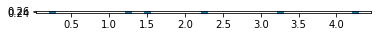

In [74]:
a.plot()

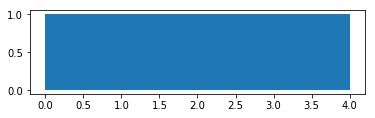

In [75]:
g2 = pd.Series([box(0,0,1,1),box(1,0,2,1),box(2,0,3,1),box(3,0,4,1)])
b = gpd.GeoDataFrame(geometry=g2)
b.plot()

In [81]:
gpd.sjoin(a,b, op="within", how='inner')

,geometry,index_right
0,POINT (0.25 0.25),0
1,POINT (1.5 0.25),1
2,POINT (1.25 0.25),1
3,POINT (2.25 0.25),2
4,POINT (3.25 0.25),3


In [172]:
a = box(0,0,1,1)
b = Point(0,0)
c = Point(.5,.5)
d = Point(.5,0)
a.contains(d)

False

## merge bathymetry data

In [188]:
bathymetry.head()
bathymetry.shape

(5371, 4)

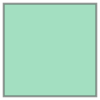

In [16]:
grid_df.iloc[0].geometry

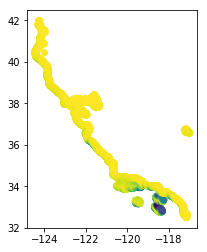

In [189]:
bathymetry.plot(column='z')

In [222]:
def get_value_at_point(shape, pnts, vals, n_closest=5):
    distances = [shape.distance(i) for i in pnts]
    closest_points = np.argsort(distances)[:n_closest]
    return np.mean(vals.iloc[closest_points])

In [197]:
#get_value_at_point(grid_df.geometry, ocean_bathymetry.geometry, ocean_bathymetry.z)
grid_df['depth'] = grid_df.geometry.apply(lambda x: get_value_at_point(x, ocean_bathymetry.geometry, ocean_bathymetry.z))
grid_df.head()

,geometry,polygon_id,land_distance,pretected_areas,county,biomass,depth
0,"POLYGON ((-124.511849 40.2062109680851, -124.4...",77,4.785556,"[(13, Sea Lion Gulch State Marine Reserve, 0.0...","[(21, Humboldt, 4.785556275622082)]",0.0,-122.4
1,"POLYGON ((-124.511849 40.30584561702128, -124....",78,2.007310,"[(12, Mattole Canyon State Marine Reserve, 0.0...","[(21, Humboldt, 2.00731033547805)]",0.0,-45.0
2,"POLYGON ((-124.511849 40.40548026595744, -124....",79,0.222856,"[(9, Sugarloaf Island Special Closure, 0.0), (...","[(21, Humboldt, 0.22285562284475044)]",0.0,-29.6
3,"POLYGON ((-124.511849 40.50511491489362, -124....",80,2.325414,"[(9, Sugarloaf Island Special Closure, 6.54469...","[(21, Humboldt, 2.32541354349618)]",0.0,-38.6
4,POLYGON ((-124.4120138767123 40.10657631914894...,171,1.252525,"[(14, Big Flat State Marine Conservation Area,...","[(21, Humboldt, 1.2525254119315425)]",0.0,-58.2


# merge sst data

In [206]:
sst.head()

,mean_temp,max_temp,min_temp,geometry
0,16.686864,19.299982,14.749994,POINT (-124 32.5)
1,16.615615,19.239984,14.249994,POINT (-123.75 32.5)
2,16.574993,19.200006,13.829980,POINT (-123.5 32.5)
3,16.543119,19.159998,13.589990,POINT (-123.25 32.5)
4,16.536871,19.129999,13.359979,POINT (-123 32.5)


In [225]:
grid_df['mean_sst'] = grid_df.geometry.apply(lambda x: get_value_at_point(x, sst.geometry, sst.mean_temp))
grid_df['max_sst'] = grid_df.geometry.apply(lambda x: get_value_at_point(x, sst.geometry, sst.max_temp))
grid_df['min_sst'] = grid_df.geometry.apply(lambda x: get_value_at_point(x, sst.geometry, sst.min_temp))
#a = get_value_at_point(grid_df.iloc[1].geometry, sst.geometry,sst.mean_temp)
#print(a)
#print(sst.iloc[898])
grid_df.head()

,geometry,polygon_id,land_distance,pretected_areas,county,biomass,depth,,critical_species,mean_sst,max_sst,min_sst
0,"POLYGON ((-124.511849 40.2062109680851, -124.4...",77,4.785556,"[(13, Sea Lion Gulch State Marine Reserve, 0.0...","[(21, Humboldt, 4.785556275622082)]",0.0,-122.4,"[(41, green sturgeon, 0.0), (22, stellar sea l...","[(41, green sturgeon, 0.0), (22, stellar sea l...",11.929242,14.013989,9.125995
1,"POLYGON ((-124.511849 40.30584561702128, -124....",78,2.007310,"[(12, Mattole Canyon State Marine Reserve, 0.0...","[(21, Humboldt, 2.00731033547805)]",0.0,-45.0,"[(41, green sturgeon, 0.0), (22, stellar sea l...","[(41, green sturgeon, 0.0), (22, stellar sea l...",11.929242,14.013989,9.125995
2,"POLYGON ((-124.511849 40.40548026595744, -124....",79,0.222856,"[(9, Sugarloaf Island Special Closure, 0.0), (...","[(21, Humboldt, 0.22285562284475044)]",0.0,-29.6,"[(41, green sturgeon, 0.0), (28, stellar sea l...","[(41, green sturgeon, 0.0), (28, stellar sea l...",11.929242,14.013989,9.125995
3,"POLYGON ((-124.511849 40.50511491489362, -124....",80,2.325414,"[(9, Sugarloaf Island Special Closure, 6.54469...","[(21, Humboldt, 2.32541354349618)]",0.0,-38.6,"[(41, green sturgeon, 0.0), (22, stellar sea l...","[(41, green sturgeon, 0.0), (22, stellar sea l...",11.929242,14.013989,9.125995
4,POLYGON ((-124.4120138767123 40.10657631914894...,171,1.252525,"[(14, Big Flat State Marine Conservation Area,...","[(21, Humboldt, 1.2525254119315425)]",0.0,-58.2,"[(41, green sturgeon, 0.0), (22, stellar sea l...","[(41, green sturgeon, 0.0), (22, stellar sea l...",11.929242,14.013989,9.125995
